## EKF Imeplementation

This Notebook contains codes to implement Extended Kalman Filter on a JetBot.

In [355]:
import os
import pickle
import cv2
import numpy as np
import math
import time

%matplotlib inline
import matplotlib.pyplot as plt
import ipywidgets.widgets as widgets
from IPython.display import display

from jetbot import bgr8_to_jpeg
from jetbot import ObjectDetector
from jetbot import Camera
from jetbot import Robot


In [137]:
model = ObjectDetector('../Notebooks/object_following/ssd_mobilenet_v2_coco.engine')
camera = Camera.instance(width=300, height=300)
robot = Robot()

Directories not created because they already exist


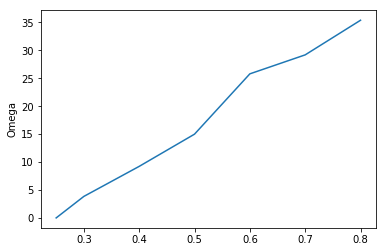

In [356]:
# Load COCO labels
filename = "coco_labels.dat"
filehandler = open(filename, 'rb')
COCO_labels = pickle.load(filehandler)

# Load camera calibration data for undistort
filename = "calibration.dat"
filehandler = open(filename, 'rb')
camera_cal = pickle.load(filehandler)
mtx = camera_cal['mtx']
dist = camera_cal['dist']
f_u = mtx[0,0]  # focal lengths in u pixels (image plane horizontal)
f_v = mtx[1,1]  # focal lengths in v pixels (image plane vertical)
c_u = mtx[0,2]  # focal center in u pixels (image plane horizontal)
c_v = mtx[1,2]  # focal center in v pixels (image plane vertical)
focal_center = np.array([c_u, c_v])

# Open Image Widget
image_widget = widgets.Image(format='jpeg', width=300, height=300)
width = int(image_widget.width)
height = int(image_widget.height)

BLUE = (255, 0, 0)
GREEN = (0, 255, 0)
RED = (0, 0, 255)

diag_dir = 'diagnostics'
# we have this "try/except" statement because these next functions can throw an error if the directories exist already
try:
    os.makedirs(diag_dir)
except FileExistsError:
    print('Directories not created because they already exist')

# Mapping between set_motor "speed" and measured wheel angular velocity "omega"
# for 0.1 second motor running time
wheel_calibration = {
    "speed": [0.25, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8],
    "omega": [0.0, 3.85, 9.23, 15.0, 25.8, 29.2, 35.4]
}

plt.plot(wheel_calibration["speed"],wheel_calibration["omega"])
plt.ylabel('Omega')
# fig = plt.figure(figsize=(4, 5))
plt.savefig('test.png')
plt.show()

In [545]:
def forward(wheel_speed, Rtime):

    robot.set_motors(wheel_speed, wheel_speed)
    time.sleep(Rtime)
    robot.stop()
    
    return

def control2robot(wheel_radius, axle_length):
    """ transform wheel speeds to robot motion in world frame """
    l = axle_length
    r = wheel_radius

    return np.array([[r/2, r/2],
                  [r/l, -r/l]])

def omega2speed(in_val, mapping, debug=False):
    """ Map wheel angular speed to motor speed setting based on a calibration mapping """
    
    if in_val < 0:
        sign = -1
        in_val = abs(in_val)
    else:
        sign = 1
        
    out_lower = 0
    in_lower = 0
    out_val = 0

    for i, in_upper in enumerate(mapping["omega"]):
        if debug:
            print (i, in_upper)
        if in_val < in_upper:
            out_upper = mapping["speed"][i]
            out_val = out_lower + (in_val - in_lower)/(in_upper - in_lower) \
                *(out_upper-out_lower)
            if debug:
                print("yes", out_val)
            break
        else:
            if debug:
                print("no")
            out_lower = mapping["speed"][i]
            in_lower = in_upper
            
    if out_val is 0:
        print ("Input is too high!!!", in_val)
        out_val = 0
        
    return sign*out_val


def calc_wheel_velocities(direction='L', arc_radius=0.5, min_ang_vel=3.85, \
       wheel_radius=0.0325, axle_length=0.12, debug = False):
    """ Calculate wheel velocities to generate forward arc motion of provided radius """

    radius = arc_radius
    axle = axle_length
    
    if direction is 'L':
        """ If left turn, angular velocity of right wheel should be higher.
        Set angular velocity of left wheel to minumum (e.g. 3.85--> motor setting of 0.3) """
        l_ang_vel = min_ang_vel
        r_ang_vel = (min_ang_vel*2)/(2*radius/axle-1)+min_ang_vel
    else:
        """ If right turn, angular velocity of left wheel should be higher.
        Set angular velocity of right wheel to minumum (e.g. 3.85--> motor setting of 0.3) """
        r_ang_vel = min_ang_vel    
        l_ang_vel = (min_ang_vel*2)/(2*radius/axle-1)+min_ang_vel
    
    if debug:
        print ("Left angular velocity:",l_ang_vel, " Right angular velocity:",r_ang_vel)
        T = control2robot(wheel_radius, axle_length)
        robot_velocities = np.dot(T, np.array([[r_ang_vel],[l_ang_vel]]))
        print ("Robot velocities:", robot_velocities)
        print("arc radius = ",abs(robot_velocities[0,0]/robot_velocities[1,0]))
    
    return np.array([[r_ang_vel],[l_ang_vel]])

def update_map(Mu, Mu_prev, landmarks, debug=False):
    """ Update robot position on map """
    plt.figure(figsize=(6,6))
    plt.xlim([0,180])
    plt.ylim([0,180])
    
    """ Display robot as line + triangle (arrow) """
    robot_x = Mu[0,0]*100
    robot_y = Mu[1,0]*100
    robot_theta = Mu[2,0]*180/math.pi - 90 # Adjust orientation to match matplotlib
    
    if debug:
        print("(x,y):{:.1f}, {:.1f}".format(robot_x,robot_y))
        print("Orientation: {:.1f}".format(Mu[2,0]*180/math.pi))
    
    # robot = line + triangle
    plt.plot(robot_x, robot_y, marker=(2, 0, robot_theta), c='k',markersize=15, linestyle='None')
    plt.plot(robot_x, robot_y, marker=(3, 0, robot_theta), c='k',markersize=10, linestyle='None')
    
    """ Display landmark as green cross, uncorrected landmark as lime cross """
    for i, landmark in enumerate(landmarks):
        if landmark['observed'] is True:
            # Mark landmark (pre-Kalman correction)
            landmark_x_prev = Mu_prev[3+2*i]*100
            landmark_y_prev = Mu_prev[3+2*i+1]*100
            plt.plot(landmark_x_prev, landmark_y_prev, marker='x', markersize=12, color='lime') 
            # Mark landmark (post-Kalman correction)
            landmark_x = Mu[3+2*i]*100
            landmark_y = Mu[3+2*i+1]*100
            plt.plot(landmark_x, landmark_y,marker='x', markersize=12, color='green')
            plt.text(landmark_x, landmark_y+10, landmark["obj_name"])
    plt.show()
    return

def undistort(img, mtx, dist, crop=False):
    """Undistort camera image based on calibration data"""
    h,w = img.shape[:2]
    # print (h,w)
    newcameramtx, roi=cv2.getOptimalNewCameraMatrix(mtx,dist,(w,h),1,(w,h))
    
    # undistort
    dst = cv2.undistort(img, mtx, dist, None, newcameramtx)

    # crop the image (optional)
    if crop:
        x,y,w,h = roi
        dst = dst[y:y+h, x:x+w]
    return dst

def draw_bbox(img, width, height, bbox, color, line_width):
    bbox_pixel = [(int(width * bbox[0]), int(height * bbox[1])), 
                  (int(width * bbox[2]), int(height * bbox[3]))]
    cv2.rectangle(img, bbox_pixel[0], bbox_pixel[1], color, line_width)
    return bbox_pixel

def valid_bbox(bbox, width, height):
    """ Detect if an object borders the 4 edges of the camera image plane. 
    Used to disregard a landmark for range and bearing estimation. """
    return (width * bbox[0]>10) and \
           (width * bbox[2]<width-10) and \
           (height * bbox[1]>10) and \
           (height * bbox[3]<height-10)

def display_landmarks(img, landmarks, width, height, debug=False):
    """ put blue bounding boxes on detected objects on image """
    
    for item in landmarks:
        label = COCO_labels[item['label']-1]
        bbox = item['bbox']
        bbox_pixel = draw_bbox(img, width, height, bbox, BLUE, 1)
        if debug:
            print(label,item['label'], bbox_pixel)
    return

def landmark_coordinates(item, width, height):
    """ calculate landmark's left, center and right in image pixel coordinates """
    u_left = item['bbox'][0] * width
    u_right = item['bbox'][2] * width
    u_center = (item['bbox'][0]+item['bbox'][2])*width/2
    return u_left, u_center, u_right

def initialize_Mu_Sigma(x,y,theta,landmark_list):
    """ Initialize Mu and Sigma """
    # Initialize Mu
    Mu = np.array([[x],[y],[theta]])
    for object in range(len(landmark_list)):
        Mu = np.vstack((Mu,np.array([[0],[0]])))
    N = Mu.shape[0]   # N=3+2n, n=num of landmarks

    # Initialize Sigma - For Σ_mm, infinity (large num) along the diagonal and zero everywhere else 
    Sigma = np.zeros((N,N))
    Sigma[3:,3:] = np.eye(N-3)*LARGE
    
    return Mu, Sigma

def robot_pose_delta(v,w,theta,dt):
    """ Calculate change in robot pose in world frame """
    
    """ An alternate way - can avoid divide by zero error if w is zero
    x_delta = v*dt*math.cos(theta)
    y_delta = v*dt*math.sin(theta)
    """
    arc_radius = v/w   # arc radius
    
    x_delta = arc_radius*(math.sin(theta+w*dt)-math.sin(theta))
    y_delta = arc_radius*(math.cos(theta)-math.cos(theta+w*dt))
    theta_delta = w*dt
    
    return x_delta, y_delta, theta_delta

def compute_G_t(v,w,theta,dt,N):
    """ Calculate G_t matrix """ 
    F = np.zeros((3,N))
    F[0:3,0:3] = np.eye(3)
    
    """ An alternate way to avoid divide by zero error if w is zero """
    """ TBD """
    
    arc_radius = v/w   # arc radius
    
    d_x_delta = arc_radius*(math.cos(theta+w*dt)-math.cos(theta))
    d_y_delta = arc_radius*(-math.sin(theta)+math.sin(theta+w*dt))
    
    G_x_t = np.array([[0,0,d_x_delta],[0,0,d_y_delta],[0,0,0]])
    G_t = np.eye(N)+ np.dot(np.dot(F.T, G_x_t),F)
    
    return G_t

def prediction_step_update(Mu, Sigma, x_delta, y_delta, theta_delta, G_t, R_t, N):
    """
    Implement: 
         Mu_t = g(Mu_t-1, u_t) 
         Sigma_t = G_t.Sigma_t-1.G_t^T + F^T.R_t.F
    """
    F = np.zeros((3,N))
    F[0:3,0:3] = np.eye(3)
    Mu = Mu + np.dot(F.T, np.array([[x_delta],[y_delta],[theta_delta]]))
    Sigma = np.dot(np.dot(G_t, Sigma),G_t.T) + np.dot(np.dot(F.T, R_t),F)
    
    return Mu, Sigma
    
def estimate_range_bearing(landmarks, index, u_l, u_c, u_r, c_u, focal_length, camera_offset):
    """ Estimate landmark range (r) and bearing (phi) """
    
    j = index  # j is landmark index
    landmark_width = landmarks[j]['width']   # we know landmark's real width
    
    # First calculate range and bearing from camera's focal center
    phi = math.atan2(c_u-u_c, f_u) # phi is +ve if landmark is left of focal center
    depth = f_u/(u_r-u_l)*landmark_width*correct_factor-focal_length
    r = depth/math.cos(phi)

    # Next calculate range and bearing from robot's center of motion
    true_phi = math.atan2(r*math.sin(phi), depth+focal_length+camera_offset)
    true_r = (depth+focal_length+camera_offset)/math.cos(true_phi)
    
    return true_r, true_phi

def update_landmark_Mu(Mu, j, r, phi):
    """ Update j-th landmark's x and y coordinate in Mu """
    
    x = Mu[0,0] 
    y = Mu[1,0] 
    theta = Mu[2,0]
    
    Mu[3+2*j,0] = x + r*math.cos(phi+theta)
    Mu[3+2*j+1,0] = y + r*math.sin(phi+theta)
    
    return Mu

def get_observation(Mu, j):
    """ Get landmark's updated observation """
    robot_x = Mu[0,0] 
    robot_y = Mu[1,0] 
    robot_theta = Mu[2,0]
    landmark_x = Mu[3+2*j,0]
    landmark_y = Mu[3+2*j+1,0]
    
    delta = np.array([[landmark_x-robot_x],[landmark_y-robot_y]])
    q = np.asscalar(np.dot(delta.T, delta))
    z_t_hat = np.array([[math.sqrt(q)],[math.atan2(delta[1,0],delta[0,0])-robot_theta]])

    return delta, q, z_t_hat

def compute_H_t(delta, j, q, N):             
    """ Compute H_t matrix """     
    delta_x = delta[0,0]
    delta_y = delta[1,0]  
    
    F = np.zeros((5,N))
    F[0:3,0:3] = np.eye(3)
    F[3:5,3+2*j:3+2*j+2] = np.eye(2)
            
    sqrt_q = math.sqrt(q)
    H_j = np.array([[-sqrt_q*delta_x, -sqrt_q*delta_y,   0, sqrt_q*delta_x, sqrt_q*delta_y],
                    [        delta_y,        -delta_x,  -q,       -delta_y,        delta_x]])
    H_t = 1/q*np.dot(H_j,F)
    
    return H_t

def compute_Kalman_Gain(delta, q, j, H_t, Sigma, N, Q_t):
    """ Compute Kalman Gain K_t """         
    delta_x = delta[0,0]
    delta_y = delta[1,0]
            
    # Compute Kalman Gain K_t
    L = np.dot(np.dot(H_t, Sigma),H_t.T) + Q_t
    K_t = np.dot(np.dot(Sigma, H_t.T),np.linalg.inv(L))
    
    return K_t
            

In [542]:
def take_circ_step(robot_params, direction, radius, debug=False, motion=True):
    
    # load robot control parameters
    start_x = robot_params["start_x"]
    start_y = robot_params["start_y"]
    wheel_radius = robot_params["wheel_radius"]
    axle_length = robot_params["axle_length"]
    motor_on_time = robot_params["motor_on_time"]
    motor_off_time = robot_params["motor_off_time"]
    min_ang_velocity = robot_params["min_ang_velocity"]
    
    """ Generate clamped wheel velocities based on turn direction and radius """
    wheel_velocities = calc_wheel_velocities(direction='L', arc_radius=radius, \
        min_ang_vel=min_ang_velocity, \
        wheel_radius=wheel_radius, axle_length=axle_length, debug = debug)
    
    """ Map wheel angular velocities to motor setting, then run motors """ 
    w_r = omega2speed(wheel_velocities[0,0],wheel_calibration) 
    w_l = omega2speed(wheel_velocities[1,0],wheel_calibration)
    if debug:
        print ("L motor:", w_l," R motor:", w_r)
    
    """ Run motor step motion """
    if motion:
        robot.set_motors(w_l, w_r)  # left, right
        time.sleep(motor_on_time)
        robot.stop()
        time.sleep(motor_off_time)
    
    return wheel_velocities

(x,y):150.0, 75.0
Orientation: 90.0


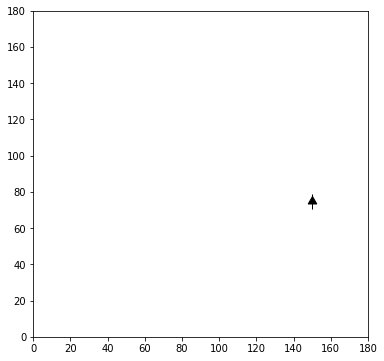

In [546]:
robot_params = {
    # pose
    "start_x": 1.5,
    "start_y": 0.75,
    "start_theta": math.pi/2,
    # physical dimensions
    "wheel_radius": 0.0325,
    "axle_length": 0.12,
    "camera_offset": 0.06, # camera is +6cm from center of wheel axle
    # stepwise motor control
    "motor_on_time": 0.1,  
    "motor_off_time": 0.2,
    # wheel velocity control
    "min_ang_velocity": 6.0, # Equivalent to motor speed setting of 0.3
    "focal_length": 0.00315 # camera focal lenght in meter
}

control_params = {
    "num_iter": 56,
    "interval": 5,
    "debug": False,
    "motion": True,
    "radius": 0.50,    # radius of circular trajectory
}

landmarks = [
    {
    "label": 19,
    "obj_name": 'horse',
    "width": 0.394,
    "observed": False
    },
    {
    "label": 47,
    "obj_name": 'cup',
    "width": 0.12,
    "observed": False
    },
    {
    "label": 44,
    "obj_name": 'bottle',
    "width": 0.10,
    "observed": False
    },
    {
    "label": 63,
    "obj_name": 'couch',
    "width": 1.68,
    "observed": False
    }
]

landmark_item_list = []
for item in landmarks:
    landmark_item_list.append(item['label'])
    
# Display camera image with bounding boxes for detected objects
display(widgets.HBox([image_widget]))
image = undistort(camera.value, mtx, dist) # undistort camera image
image_widget.value = bgr8_to_jpeg(image)  # update image widget with camera image

LARGE = 1e6
t_delta = 0.1  # motor on time
R_t = np.zeros((3,3))  # Assume zero control noise for now
Q_t = np.zeros((2,2))  # Assume zero measurement noise for now

diag_dir = 'diagnostics'
np.set_printoptions(precision=5)

# Load camera parameters
focal_length = robot_params["focal_length"]
correct_factor = 0.769
camera_offset = robot_params["camera_offset"]

# Load robot parameters
wheel_radius = robot_params["wheel_radius"]
axle_length = robot_params["axle_length"]
T = control2robot(wheel_radius,axle_length)
x = robot_params["start_x"]
y = robot_params["start_y"]
theta = robot_params["start_theta"]

# load control parameters 
num_iter = control_params["num_iter"]
interval = control_params["interval"]
motion = control_params["motion"]
debug = control_params["debug"] 
radius = control_params["radius"] 

""" Initialize Mu and Sigma """
Mu, Sigma = initialize_Mu_Sigma(x,y,theta,landmark_item_list)
Mu_prev = Mu
if debug:
    print(Mu)
    print(Sigma)

# Place robot (and landmark)on map
update_map(Mu, Mu_prev, landmarks, debug=True)

(x,y):150.0, 77.2
Orientation: 92.5


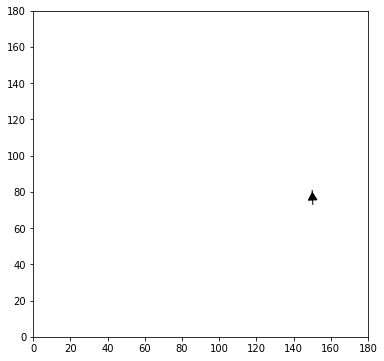

horse (left,center, right):157.1,199.5,                 241.8
horse estimated phi:-17.7 degree
horse estimated range:59.6cm
Mu: [[1.49804]
 [0.79426]
 [1.65943]
 [1.62827]
 [1.37566]
 [0.     ]
 [0.     ]
 [0.     ]
 [0.     ]
 [0.     ]
 [0.     ]]
robot: 1.5,0.6
horse: 0.6,0.8
delta: [[0.13023]
 [0.5814 ]]
q: 0.35
observation: [[ 0.59581]
 [-0.309  ]]
horse (left,center, right):172.2,226.1,                 280.1
horse estimated phi:-25.3 degree
horse estimated range:50.7cm
Mu: [[1.49216]
 [0.83817]
 [1.74807]
 [1.62497]
 [1.32771]
 [0.     ]
 [0.     ]
 [0.     ]
 [0.     ]
 [0.     ]
 [0.     ]]
robot: 1.5,0.6
horse: 0.6,0.8
delta: [[0.13611]
 [0.53749]]
q: 0.31
observation: [[ 0.50716]
 [-0.44075]]
(x,y):148.2, 88.1
Orientation: 105.2


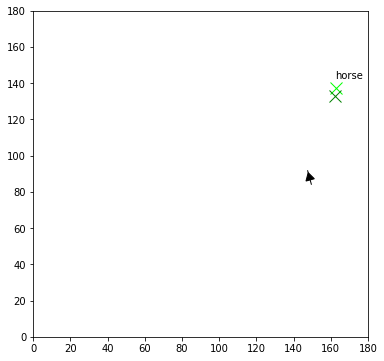

(x,y):144.2, 98.4
Orientation: 117.9


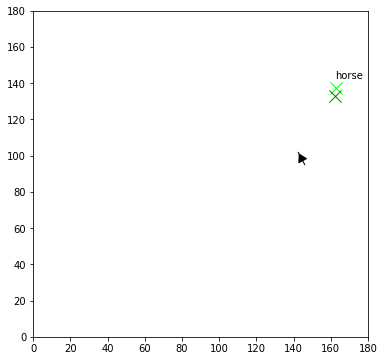

bottle (left,center, right):136.1,148.9,                 161.7
bottle estimated phi:-0.2 degree
bottle estimated range:48.6cm
Mu: [[1.39353]
 [1.05844]
 [2.23557]
 [1.62497]
 [1.32771]
 [0.     ]
 [0.     ]
 [1.09463]
 [1.44194]
 [0.     ]
 [0.     ]]
robot: 1.5,0.6
bottle: 0.6,0.8
delta: [[-0.2989]
 [ 0.3835]]
q: 0.24
observation: [[ 0.48623]
 [-0.00272]]
bottle (left,center, right):139.0,154.6,                 170.2
bottle estimated phi:-2.1 degree
bottle estimated range:41.0cm
Mu: [[1.37948]
 [1.07557]
 [2.27989]
 [1.62497]
 [1.32771]
 [0.     ]
 [0.     ]
 [1.12355]
 [1.39591]
 [0.     ]
 [0.     ]]
robot: 1.5,0.6
bottle: 0.6,0.8
delta: [[-0.28485]
 [ 0.36637]]
q: 0.22
observation: [[ 0.40999]
 [-0.03654]]
(x,y):137.9, 107.6
Orientation: 130.6


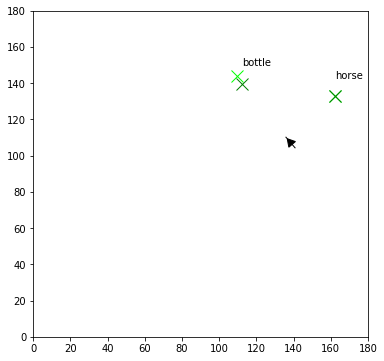

bottle (left,center, right):139.6,155.7,                 171.9
bottle estimated phi:-2.5 degree
bottle estimated range:39.9cm
Mu: [[1.36468]
 [1.09206]
 [2.32421]
 [1.62497]
 [1.32771]
 [0.     ]
 [0.     ]
 [1.10475]
 [1.39481]
 [0.     ]
 [0.     ]]
robot: 1.5,0.6
bottle: 0.6,0.8
delta: [[-0.24113]
 [ 0.30385]]
q: 0.15
observation: [[ 0.39872]
 [-0.04285]]
bottle (left,center, right):147.1,164.8,                 182.4
bottle estimated phi:-5.4 degree
bottle estimated range:37.1cm
Mu: [[1.34917]
 [1.10789]
 [2.36852]
 [1.62497]
 [1.32771]
 [0.     ]
 [0.     ]
 [1.10924]
 [1.39112]
 [0.     ]
 [0.     ]]
robot: 1.5,0.6
bottle: 0.6,0.8
delta: [[-0.24442]
 [ 0.28692]]
q: 0.14
observation: [[ 0.3712 ]
 [-0.09487]]
bottle (left,center, right):153.4,170.5,                 187.6
bottle estimated phi:-7.4 degree
bottle estimated range:38.2cm
Mu: [[1.33297]
 [1.123  ]
 [2.41284]
 [1.62497]
 [1.32771]
 [0.     ]
 [0.     ]
 [1.0834 ]
 [1.41229]
 [0.     ]
 [0.     ]]
robot: 1.5,0.6
bottle: 0.6

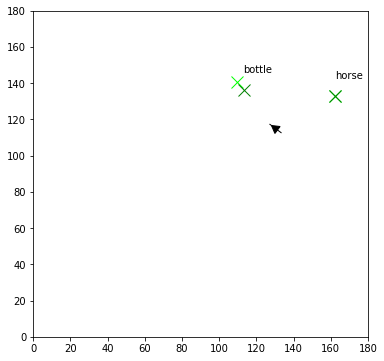

bottle (left,center, right):182.0,214.0,                 246.0
bottle estimated phi:-18.5 degree
bottle estimated range:24.3cm
Mu: [[1.28058]
 [1.16385]
 [2.5458 ]
 [1.62497]
 [1.32771]
 [0.     ]
 [0.     ]
 [1.13302]
 [1.35728]
 [0.     ]
 [0.     ]]
robot: 1.5,0.6
bottle: 0.6,0.8
delta: [[-0.14932]
 [ 0.19688]]
q: 0.06
observation: [[ 0.24329]
 [-0.32335]]
bottle (left,center, right):194.3,234.1,                 274.0
bottle estimated phi:-22.3 degree
bottle estimated range:21.3cm
Mu: [[1.26197]
 [1.17588]
 [2.59011]
 [1.62497]
 [1.32771]
 [0.     ]
 [0.     ]
 [1.13638]
 [1.34778]
 [0.     ]
 [0.     ]]
robot: 1.5,0.6
bottle: 0.6,0.8
delta: [[-0.12895]
 [ 0.1814 ]]
q: 0.05
observation: [[ 0.21287]
 [-0.38891]]
(x,y):120.3, 120.7
Orientation: 156.0


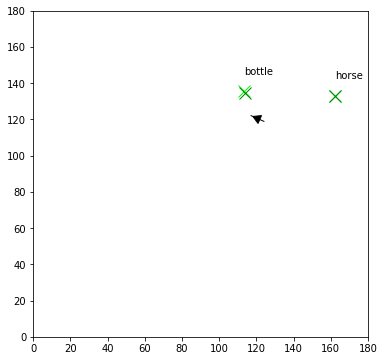

(x,y):109.8, 124.0
Orientation: 168.7


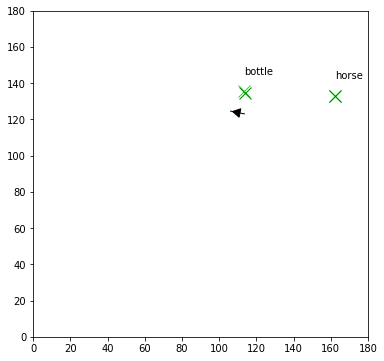

couch (left,center, right):14.1,129.8,                 245.4
couch estimated phi:7.0 degree
couch estimated range:85.9cm
Mu: [[ 1.05404]
 [ 1.24707]
 [ 3.0333 ]
 [ 1.62497]
 [ 1.32771]
 [ 0.     ]
 [ 0.     ]
 [ 1.13638]
 [ 1.34778]
 [ 0.26619]
 [-4.16305]]
robot: 1.5,0.6
couch: 0.6,0.8
delta: [[-0.85924]
 [-0.01136]]
q: 0.74
observation: [[0.85931]
 [0.12152]]
couch (left,center, right):20.6,136.4,                 252.2
couch estimated phi:4.5 degree
couch estimated range:85.5cm
Mu: [[ 1.03197]
 [ 1.24898]
 [ 3.07761]
 [ 1.62497]
 [ 1.32771]
 [ 0.     ]
 [ 0.     ]
 [ 1.13638]
 [ 1.34778]
 [27.2565 ]
 [-3.32495]]
robot: 1.5,0.6
couch: 0.6,0.8
delta: [[-0.76577]
 [-5.41203]]
q: 29.88
observation: [[0.85478]
 [0.07876]]
couch (left,center, right):12.8,132.8,                 252.9
couch estimated phi:5.8 degree
couch estimated range:82.8cm
Mu: [[ 1.00983]
 [ 1.2499 ]
 [ 3.12193]
 [ 1.62497]
 [ 1.32771]
 [ 0.     ]
 [ 0.     ]
 [ 1.13638]
 [ 1.34778]
 [17.36142]
 [90.24031]]
robot: 1.5,0.

(x,y):87.8, 123.5
Orientation: 194.1


In [ ]:
# Display camera image with bounding boxes for detected objects
display(widgets.HBox([image_widget]))

""" Robot moves stepwise in a circle """
for i in range(num_iter):
    
    """ Move robot - Take 1 step in a left circular trajectory of radius 0.4m """
    wheel_velocities = take_circ_step(robot_params, 'L', radius, debug=debug, motion=motion)
    robot_velocities = np.dot(T,wheel_velocities)   # calculate (v,omega)
    if debug:
        print("Step: ", i+1)
        print("(w_r,w_l): {}".format(wheel_velocities))
        print("(v,omega): {}".format(robot_velocities))
        
    """ =================== """        
    """ EKF Prediction Step """
    """ =================== """
    
    v = robot_velocities[0,0]
    w = robot_velocities[1,0]
    theta = Mu[2,0]  # robot orientation
    N = Mu.shape[0]   # N=3+2n, n=num of landmarks
    
    # Calculate delta in robot's pose in the world frame
    x_delta, y_delta, theta_delta = robot_pose_delta(v,w,theta,t_delta)

    G_t = compute_G_t(v,w,theta,t_delta,N)  # Generate G_t 
    
    # Update Mu and Sigma based on change in robot pose
    Mu, Sigma = prediction_step_update(Mu, Sigma, x_delta, y_delta, theta_delta, G_t, R_t, N)
    
    if debug:
        print("(dx,dy,dtheta):{:.2f},{:.2f},{:.2f}".format(x_delta,y_delta,theta_delta))
        print("Mu:",Mu)
        np.set_printoptions(suppress=True)
        print("G:",G_t)
        print("Sigma:",Sigma)
    
    """ Grab camera image, undistort and detect objects """
    image = undistort(camera.value, mtx, dist) # undistort camera image
    detections = model(image) # Use SSD model to detect objects
    
    """ Identify landmarks and estimate range(r)/bearing(phi) from robot """
    items = []
    for det in detections[0]:
        
        coco_id =det['label']
        if coco_id in landmark_item_list and valid_bbox(det["bbox"], width, height):
            """ If object detected is a landmark and its bounding box does not 
            borders the edges of the camera video """
            
            # Obtain landmark's left, center and right in horizontal pixel coordinate
            u_l, u_c, u_r = landmark_coordinates(det, width, height)
            j = landmark_item_list.index(coco_id)   # get landmark's index
            
            # Estimate landmark's range and bearing(r,phi) from robot
            r, phi = estimate_range_bearing(landmarks, j, \
                                            u_l, u_c, u_r, \
                                            c_u, focal_length, camera_offset)
            z_t = np.array([[r],[phi]])  # z_t - actual observation

            """ If landmark j encountered for 1st time, update (Mu_j_x, Mu_j_y) """
            if landmarks[j]['observed'] is False:
                # Update Mu's landmark coordinate
                landmarks[j]['observed'] = True
                Mu = update_landmark_Mu(Mu, j,  r, phi)

            # Get landmark j's expected observation
            delta, q, z_t_hat = get_observation(Mu, j)  # z_t_hat - expected observation
            
            # Compute H_t 
            H_t = compute_H_t(delta, j, q, N)  
            
            # Compute Kalmain Gain K_t
            K_t = compute_Kalman_Gain(delta, q, j, H_t, Sigma, N, Q_t)
            
            Mu_prev = Mu
            Mu = Mu_prev + np.dot(K_t, (z_t-z_t_hat))
            Sigma = np.dot((np.eye(N)-np.dot(K_t,H_t)), Sigma)
            
            if True:
                print("{} (left,center, right):{:.1f},{:.1f}, \
                {:.1f}".format(COCO_labels[coco_id-1], u_l, u_c, u_r))
                print("{} estimated phi:{:.1f} degree".format(COCO_labels[coco_id-1],phi/3.14*180))
                print("{} estimated range:{:.1f}cm".format(COCO_labels[coco_id-1],r*100)) 
                print("Mu:", Mu)
                print("robot: {:.1f},{:.1f}".format(robot_x, robot_y)) 
                print("{}: {:.1f},{:.1f}".format(COCO_labels[coco_id-1],landmark_x, landmark_y))   
                print("delta:", delta)
                print("q: {:.2f}".format(q))
                print("observation:", z_t)
                
            items.append(det)  # save item to display bounding box in image
            
    # Update robot and landmark on map
    if i%interval==0:
        update_map(Mu,Mu_prev,landmarks,debug=True)
    
    cv2.line(image,(int(c_u),0),(int(c_u),300),GREEN,1)        
    display_landmarks(image, items, width, height, debug) # put bounding boxes on detected objects
    image_widget.value = bgr8_to_jpeg(image)  # update image widget with camera image
    

In [483]:
# Make approx 3 to 4 circular runs - 300 steps
for i in range(3):
    take_circ_step(robot_params, 'L', 0.5, debug=False)

In [333]:
robot.stop()

In [529]:
K_t.shape

(11, 2)

In [527]:
np.dot(K_t, (z_t-z_t_hat))

array([[ 0.     ],
       [ 0.     ],
       [ 0.     ],
       [ 0.     ],
       [ 0.     ],
       [ 0.     ],
       [ 0.     ],
       [ 0.     ],
       [ 0.     ],
       [-0.0496 ],
       [ 0.00236]])

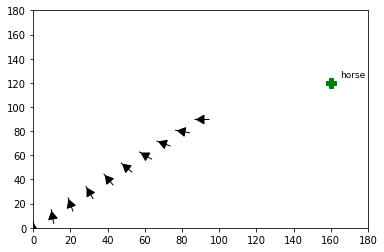

In [335]:
x = [0,10,20,30,40,50,60,70,80,90]

for i in x:
    plt.plot(i, i, marker=(2, 0, i), c='k',markersize=15, linestyle='None')
    plt.plot(i, i, marker=(3, 0, i), c='k',markersize=10, linestyle='None')

plt.plot(160, 120, marker='P', markersize=10, color='green', )
plt.text(165, 125, "horse", fontsize=9)

plt.xlim([0,180])
plt.ylim([0,180])

plt.show()


In [336]:
for i in range(18):
    theta = math.pi/(18-i+1)
    print(theta, math.sin(theta+0.057353)-math.sin(theta))

0.16534698176788384 0.05626913948353665
0.17453292519943295 0.05616520134464176
0.18479956785822313 0.056043427196913076
0.19634954084936207 0.055899371057812786
0.20943951023931953 0.055727093825776924
0.2243994752564138 0.05551851525397622
0.241660973353061 0.05526241163181744
0.2617993877991494 0.05494281908848597
0.28559933214452665 0.05453640277956778
0.3141592653589793 0.05400794990310209
0.3490658503988659 0.053302288803685705
0.39269908169872414 0.05232899797089824
0.4487989505128276 0.05093153766428349
0.5235987755982988 0.048819813189689254
0.6283185307179586 0.04540766271047081
0.7853981633974483 0.03936981770057113
1.0471975511965976 0.027236834196859072
1.5707963267948966 -0.0016442325233999577
